# Make Classification Data and get it ready

In [15]:
from sklearn.datasets import make_circles


# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [16]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [17]:
# check different labels
circles.label.value_counts()
# We have a balanced dataset

label
1    500
0    500
Name: count, dtype: int64

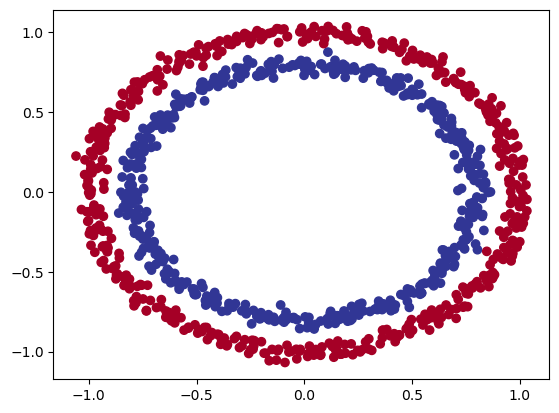

In [18]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(
    x=X[:,0],
    y= X[:,1],
    c=y,
    cmap=plt.cm.RdYlBu
)

With these data points we aim to build a binary classifier for the red and blue dots

# input and output shapes

In [19]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [20]:
# It often helps to visualize the values and shapes of a single sample, in terms of features and labels
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


In [21]:
# lets turn data into tensors
import torch 
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [23]:
# lets split the data into training and test sets using a 80-20 split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

# Building a model

1. Setting up device agnostic code (so our model can run on CPU or GPU if it's available).
2. Constructing a model by subclassing nn.Module.
3. Defining a loss function and optimizer.
4. Creating a training loop

In [26]:
import torch 
from torch import nn 

# 1. make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu" 
device

'cpu'

In [25]:
# 2. Construct the model

class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer1 = nn.Linear(in_features=2, out_features=5)
        self.layer2 = nn.Linear(in_features=5, out_features=1)

    # forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the shape as y
        return self.layer2( # (5 input features, 1 output)
            self.layer1(    # (2 input features, 5 output)
                x           # x.shape(n samples, 2 features)
            )
        )


model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
# You can also do the same as above using nn.Sequential.
# nn.Sequential performs a forward pass computation of the input data through the layers in the order they appear

# Replicate CircleModelV0 with nn.Sequential
# model_0 = nn.Sequential(
#     nn.Linear(in_features=2, out_features=5),
#     nn.Linear(in_features=5, out_features=1)
# ).to(device)

# model_0

# nn.Sequential is fantastic for straight-forward computations, however, as the namespace says, 
# it always runs in sequential order.
# So if you'd like something else to happen (rather than just straight-forward sequential computation) 
# you'll want to define your own custom nn.Module subclass.

In [27]:
# Let make a prediction to see what happens

untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.6805],
        [-0.4971],
        [-0.8269],
        [-0.6404],
        [-0.2960],
        [-0.1881],
        [-0.0924],
        [-0.0187],
        [-0.8491],
        [-0.4789]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [29]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.1)

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

# Training

In [31]:
# Let's first make some predictions with our untrained model
# so we can get the logits
y_logits =  model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.6805],
        [-0.4971],
        [-0.8269],
        [-0.6404],
        [-0.2960]], grad_fn=<SliceBackward0>)

In [33]:
# let's get the probabilities by passing the logits through a sigmoid function
y_pred_probs =  torch.sigmoid(y_logits)
y_pred_probs, y_pred_probs.shape

(tensor([[0.3361],
         [0.3782],
         [0.3043],
         [0.3451],
         [0.4265]], grad_fn=<SigmoidBackward0>),
 torch.Size([5, 1]))

In [42]:
# To turn the prediction probabilities into prediction labels, we can round the outputs of th sigmoid activation function
y_preds = torch.round(y_pred_probs)

# In full 
y_pred_labels = torch.round(
    torch.sigmoid(
        model_0(X_test.to(device))[:5]
    )
)

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()


tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

In [44]:
# Lets bu ild a training and testing loop
 
#set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loops 
for epoch in range(epochs):
    # ===== TRAINING ======
    # Set the model to training mode
    model_0

    # 1. Forward pass
    y_logits = (
        model_0(
            X_train
        )
        # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
        .squeeze() 
    )
    y_pred = torch.round(
        torch.sigmoid(y_logits) # turn logits -> pred probs -> pred labls
    )

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss =loss_fn(
        y_logits, # Using nn.BCEWithLogitsLoss works with raw logits                   
        y_train
    )
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss Backward 
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # ===== TESTING =====
    # Set the model to evaluation mode
    model_0.eval()
    
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caluclate loss and accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred = test_pred)
        # print out logs every 10 epochs
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

  



Epoch: 0 | Loss: 0.73347, Accuracy: 50.00% | Test loss: 0.73478, Test acc: 49.00%
Epoch: 10 | Loss: 0.70928, Accuracy: 42.50% | Test loss: 0.71166, Test acc: 43.50%
Epoch: 20 | Loss: 0.70020, Accuracy: 48.38% | Test loss: 0.70261, Test acc: 45.00%
Epoch: 30 | Loss: 0.69658, Accuracy: 48.88% | Test loss: 0.69879, Test acc: 46.50%
Epoch: 40 | Loss: 0.69502, Accuracy: 49.25% | Test loss: 0.69704, Test acc: 49.50%
Epoch: 50 | Loss: 0.69427, Accuracy: 49.12% | Test loss: 0.69615, Test acc: 49.50%
Epoch: 60 | Loss: 0.69386, Accuracy: 49.88% | Test loss: 0.69564, Test acc: 50.00%
Epoch: 70 | Loss: 0.69361, Accuracy: 50.00% | Test loss: 0.69533, Test acc: 49.00%
Epoch: 80 | Loss: 0.69344, Accuracy: 50.38% | Test loss: 0.69512, Test acc: 48.50%
Epoch: 90 | Loss: 0.69333, Accuracy: 51.00% | Test loss: 0.69497, Test acc: 49.00%


# Make predictions and evaluate the model

In [47]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


helper_functions.py already exists, skipping download


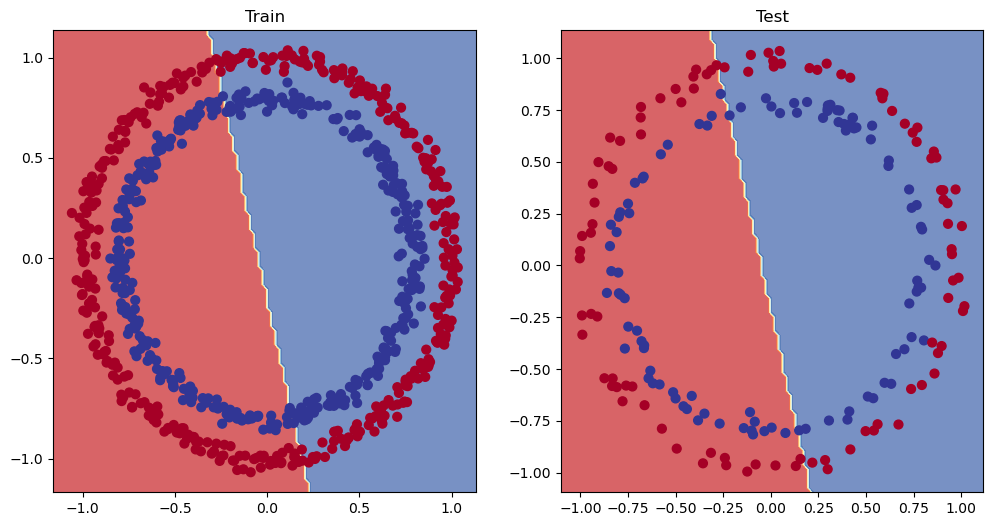

In [48]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# Improving the model

In [50]:
# Adding an extra layer to our model

class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):        
        return self.layer3(
            self.layer2(
                self.layer1(
                    x
                )
            )
        )

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [51]:
# Lets declare again our loss function and optimizer

# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [53]:
# lets train the model for longer (1000 epochs)

epochs = 1000 

# put data to target device 
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### ===== TRAINING =====
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()


    ### ===== TESTING =====
    # Set the model to evaluation mode
    model_1.eval()

    with torch.inference_mode():
        # 1. Forward pass 
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Calculate loss and accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

        # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69409, Accuracy: 51.75% | Test loss: 0.69428, Test acc: 54.50%
Epoch: 100 | Loss: 0.69313, Accuracy: 50.88% | Test loss: 0.69440, Test acc: 49.50%
Epoch: 200 | Loss: 0.69301, Accuracy: 50.88% | Test loss: 0.69458, Test acc: 46.00%
Epoch: 300 | Loss: 0.69299, Accuracy: 50.88% | Test loss: 0.69465, Test acc: 47.50%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.50%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.38% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.50% | Test loss: 0.69468, Test acc: 45.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.25% | Test loss: 0.69468, Test acc: 45.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69468, Test acc: 45.50%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69468, Test acc: 46.00%


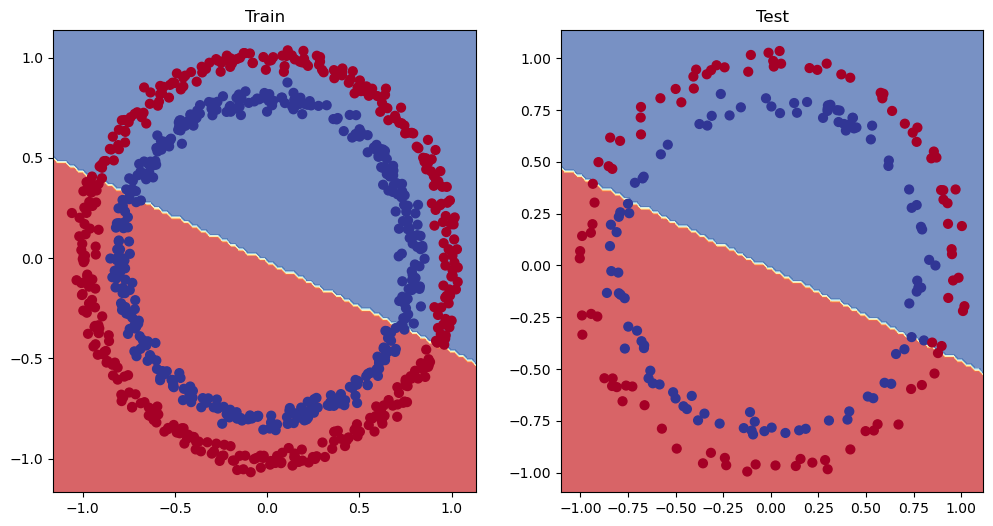

In [54]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

#### Preparing data to see if our model can model a straight line

In [57]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(f"X_regression shape: {X_regression.shape}, y_regression shape: {y_regression.shape}")
print(len(X_regression))
X_regression[:5], y_regression[:5]


X_regression shape: torch.Size([100, 1]), y_regression shape: torch.Size([100, 1])
100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

80 80 20 20


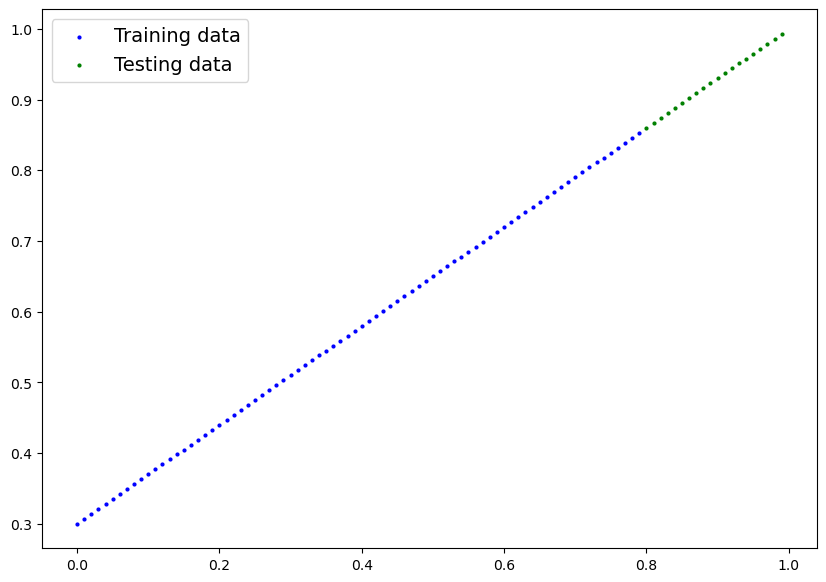

In [59]:

# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression), 
    len(y_train_regression), 
    len(X_test_regression), 
    len(y_test_regression))

# And visualize the data
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

In [68]:
# Lets adjust our model to fit a straight line
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

# Loss and optimizer
loss_fn = nn.L1Loss() # L1Loss for regression
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [69]:
# Train the model 
epochs = 1000
torch.manual_seed(42) # Set random seed for reproducibility

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### ===== TRAINING =====
    # 1. Forward pass
    y_pred = model_2(X_train_regression)
    
    # 2. Calculate loss 
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards 
    loss.backward()

    # 5. Optimizer step
    optimizer.step()
   
   # ===== TESTING =====
    model_2.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_preds = model_2(X_test_regression)
        # 2. Calculate loss
        test_loss = loss_fn(test_preds, y_test_regression)
        # Print out what's happening every 100 epochs
        # Print out what's happening

    if epoch % 100 == 0: 
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.75986, Test loss: 0.54143
Epoch: 100 | Train loss: 0.09309, Test loss: 0.02901
Epoch: 200 | Train loss: 0.07376, Test loss: 0.02850
Epoch: 300 | Train loss: 0.06745, Test loss: 0.00615
Epoch: 400 | Train loss: 0.06107, Test loss: 0.02004
Epoch: 500 | Train loss: 0.05698, Test loss: 0.01061
Epoch: 600 | Train loss: 0.04857, Test loss: 0.01326
Epoch: 700 | Train loss: 0.06109, Test loss: 0.02127
Epoch: 800 | Train loss: 0.05600, Test loss: 0.01425
Epoch: 900 | Train loss: 0.05571, Test loss: 0.00603


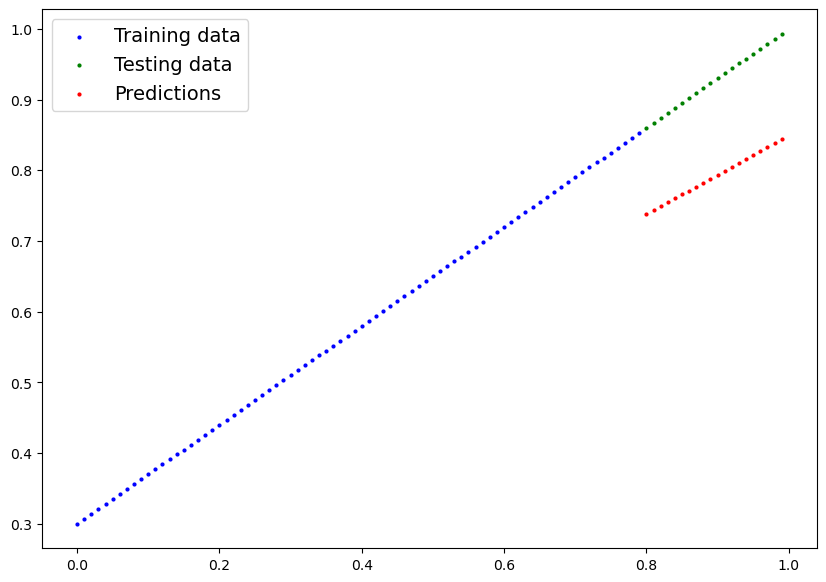

In [70]:
# Visualize tje predictions, take into account that we may be using a GPU, and 
# matplotlib needs data for CPU.

# Turn on evaluation mode
model_2.eval()

# Make predictions
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

# Adding Non-Linearity

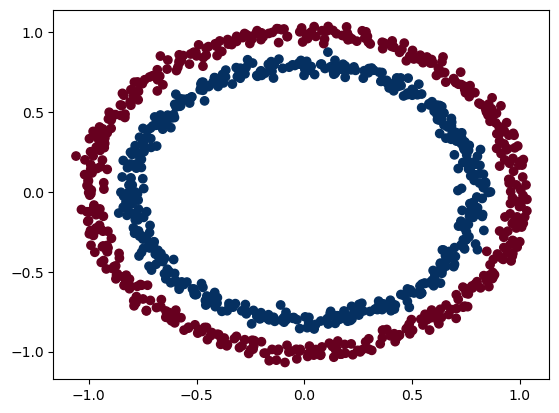

In [71]:
# lets re-create our previous circles data 
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [72]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [80]:
# Lets build a model with non-linearity
from torch import nn

class CircleModelV3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Intersperse the ReLU activation function between layers
        x = self.relu(self.layer_1(x))
        x = self.relu(self.layer_2(x))
        x = self.layer_3(x)
        return x

model_3 = CircleModelV3().to(device)
print(model_3)

# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

CircleModelV3(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [81]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70683, Accuracy: 50.00% | Test Loss: 0.70463, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69301, Accuracy: 49.75% | Test Loss: 0.69122, Test Accuracy: 54.00%
Epoch: 200 | Loss: 0.69129, Accuracy: 50.75% | Test Loss: 0.68961, Test Accuracy: 56.00%
Epoch: 300 | Loss: 0.68996, Accuracy: 51.38% | Test Loss: 0.68847, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68842, Accuracy: 52.50% | Test Loss: 0.68704, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68640, Accuracy: 52.62% | Test Loss: 0.68518, Test Accuracy: 55.50%
Epoch: 600 | Loss: 0.68360, Accuracy: 53.37% | Test Loss: 0.68279, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.67949, Accuracy: 61.88% | Test Loss: 0.67972, Test Accuracy: 61.00%
Epoch: 800 | Loss: 0.67328, Accuracy: 63.88% | Test Loss: 0.67545, Test Accuracy: 58.50%
Epoch: 900 | Loss: 0.66395, Accuracy: 66.88% | Test Loss: 0.66929, Test Accuracy: 61.00%


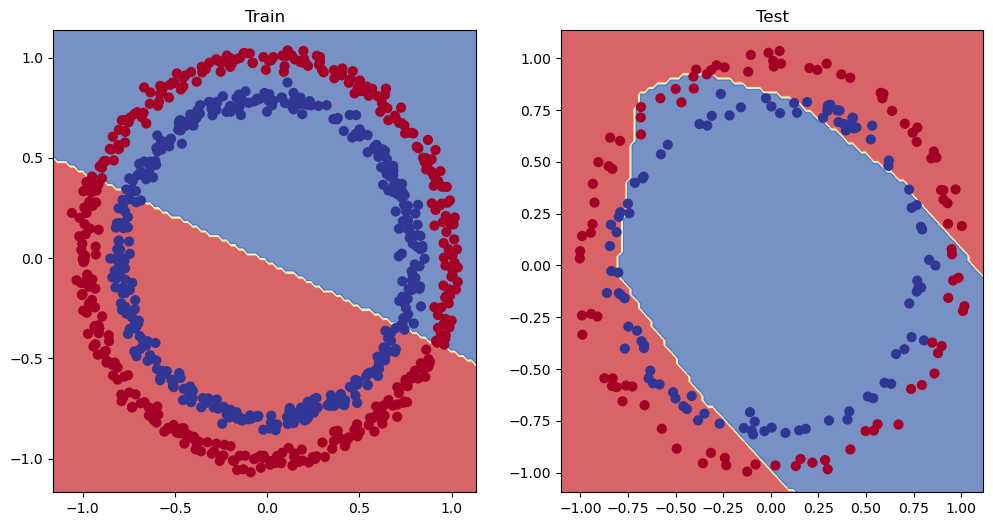

In [82]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity